In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import os
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder


from tqdm import tqdm

In [9]:
data_dir = './xray_dataset/'
# convert all input images to square tensors
# this step is probably ruining the data
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.Grayscale(num_output_channels=1),
    # normalize the data
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])


In [28]:
# Load training data
train_data = ImageFolder(root=data_dir + 'train', transform=transform)

# Load validation data
val_data = ImageFolder(root=data_dir + 'val', transform=transform)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)

# Load test data
test_data = ImageFolder(root=data_dir + 'test', transform=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

### Data loaders

In [11]:
# from torch.utils.data import DataLoader, TensorDataset

# # Create TensorDataset objects
# train_dataset = TensorDataset(train_data, train_labels)
# val_dataset = TensorDataset(val_data, val_labels)
# test_dataset = TensorDataset(test_data, test_labels)

# # Create DataLoader objects
batch_size = 32
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Let's do some displaying

### Let's do some training

In [12]:
from torch.utils.data import DataLoader, WeightedRandomSampler

# Calculate class weights
class_counts = [0] * len(train_data.classes)
print(class_counts)
labels_ = [label for _, label in tqdm(train_data)]
for label in tqdm(labels_):
    class_counts[label] += 1
class_weights = [1.0 / count for count in class_counts]
sample_weights = [class_weights[label] for label in labels_]


# Create weighted sampler and data loader
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

[0, 0]


100%|██████████| 5216/5216 [00:00<00:00, 5439455.41it/s]


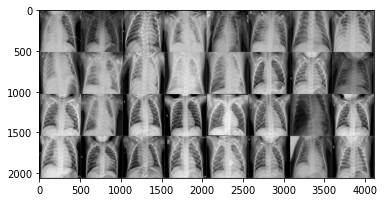

1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 1 1 0 1 0 0 1 0


In [13]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{labels[j]}' for j in range(batch_size)))


In [16]:
import torch.optim as optim
from CNN import *


net = CNN()
device = torch.device("mps")
net.to(device)

criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).to(device))
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [21]:
EPOCHS = 5
PRINT_EVERY = 40

for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # move inputs and labels to MPS device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % PRINT_EVERY == PRINT_EVERY - 1:
            # Calculate validation set loss and accuracy
            val_loss = 0.0
            val_total = 0
            val_correct = 0
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = val_data
                    val_inputs = val_inputs.to(device)
                    val_labels = val_labels.to(device)
                    val_outputs = net(val_inputs)
                    val_loss += criterion(val_outputs, val_labels).item()
                    _, val_predicted = torch.max(val_outputs.data, 1)
                    val_total += val_labels.size(0)
                    val_correct += (val_predicted == val_labels).sum().item()
            val_loss /= len(val_loader)
            val_acc = 100 * val_correct / val_total

            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / PRINT_EVERY:.3f}, '
                  f'val_loss: {val_loss:.3f}, val_acc: {val_acc:.2f}%')
            running_loss = 0.0

    # Calculate test set loss and accuracy
    test_loss = 0.0
    test_total = 0
    test_correct = 0
    with torch.no_grad():
        for test_data in test_loader:
            test_inputs, test_labels = test_data
            test_inputs = test_inputs.to(device)
            test_labels = test_labels.to(device)
            test_outputs = net(test_inputs)
            test_loss += criterion(test_outputs, test_labels).item()
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_total += test_labels.size(0)
            test_correct += (test_predicted == test_labels).sum().item()
    test_loss /= len(test_loader)
    test_acc = 100 * test_correct / test_total

    print(f'Test set loss for EPOCH {epoch}: {test_loss:.3f}, test_acc: {test_acc:.2f}%')


print('Finished Training')

[1,    40] loss: 0.007, val_loss: 0.071, val_acc: 100.00%
[1,    80] loss: 0.011, val_loss: 0.085, val_acc: 93.75%
[1,   120] loss: 0.026, val_loss: 0.302, val_acc: 87.50%
[1,   160] loss: 0.031, val_loss: 0.321, val_acc: 93.75%
Test set loss for EPOCH 0: 3.260, test_acc: 71.96%
[2,    40] loss: 0.006, val_loss: 0.040, val_acc: 100.00%


KeyboardInterrupt: 

In [25]:
# save the model
MODEL_PATH = './xray_net.pth'
torch.save(net.state_dict(), MODEL_PATH)


In [ ]:
print(f'Test set loss: {test_loss:.3f}, test_acc: {test_acc:.2f}%')

Test set loss: 1.312, test_acc: 69.23%


## Q3

In [59]:
# def integrated_gradients(input_image, model, target_class_idx, baseline=None, num_steps=50):
#     if baseline is None:
#         baseline = torch.zeros_like(input_image)

#     # interpolate between the baseline and the input image
#     interpolated_images = []
#     for step in range(num_steps + 1):
#         alpha = step / num_steps
#         interpolated_image = baseline + alpha * (input_image - baseline)
#         interpolated_images.append(interpolated_image[0].requires_grad_())

#     stacked_interpolated_images = torch.stack(
#         interpolated_images).requires_grad_()
#     print(stacked_interpolated_images.shape)
#     # compute the gradients of the output with respect to the interpolated images
#     output = model(stacked_interpolated_images)
#     target_output = output[:, target_class_idx].mean()
#     gradients = torch.autograd.grad(target_output, interpolated_images)[0]

#     # compute the integrated gradients
#     integrated_gradients = torch.mean(gradients, axis=0) * (input_image - baseline)

#     return integrated_gradients


In [88]:
def integrated_gradients(model, data, target, n_iter, visualize=True):
    # assert isinstance(data, np.ndarray), "data should be np.ndarray type"
    assert data.ndim == 4, "(n_batch, n_feat, h, w)"

    input_x = data
    baseline = torch.from_numpy(np.random.random(
        size=(input_x.shape))).float().to(device)

    alpha = np.linspace(0, 1, n_iter)
    alpha = torch.from_numpy(alpha).float().to(device)
    alpha = alpha.view(n_iter, *tuple(np.ones(baseline[0].ndim, dtype='int')))

    attributions = []
    for i in range(input_x.shape[0]):
        x = input_x[i].unsqueeze(0).to(device)
        base = baseline[i].unsqueeze(0).to(device)
        scaled_x = base + alpha * (x - base)
        attribution = torch.zeros(*scaled_x.shape)
        for i in range(n_iter):
            part_scaled_x = scaled_x[i:i+1].to(device)
            part_scaled_x.requires_grad = True
            part_y_hat = model(part_scaled_x)[:, target]
            attribution[i] = torch.autograd.grad(part_y_hat, part_scaled_x)[0]
        integrated = attribution.sum(axis=0) / n_iter
        integrated = integrated.to(device)
        ig = (x - base) * integrated
        ig = ig.detach().cpu().numpy().squeeze()
        attributions.append(ig)
    attributions = np.array(attributions)

    if visualize:
        plt.figure(figsize=(15, 8))
        # plt.subplot(1, 2, 1)
        # plt.imshow(data.reshape(512, 512, 1).to("cpu"), cmap='bone_r')
        # plt.grid()
        # plt.axis('off')
        plt.subplot(1, 2, 2)
        print(attributions.shape)
        plt.imshow(attributions[0], cmap='bone_r')
        plt.grid()
        plt.axis('off')
        plt.show()

    return attributions


(1, 512, 512)


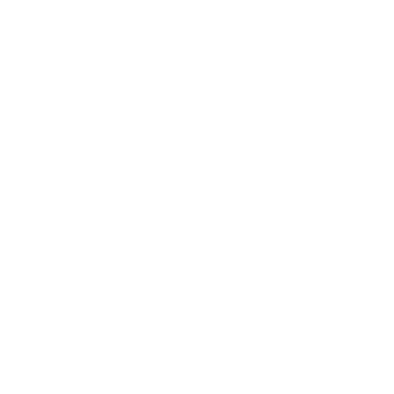

(1, 512, 512)


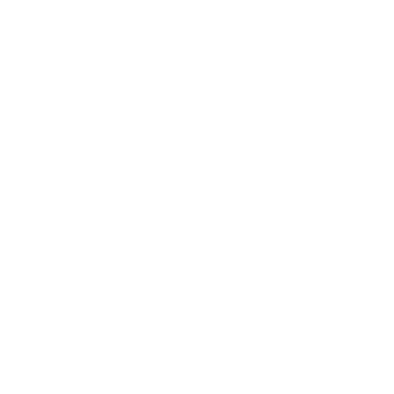

(1, 512, 512)


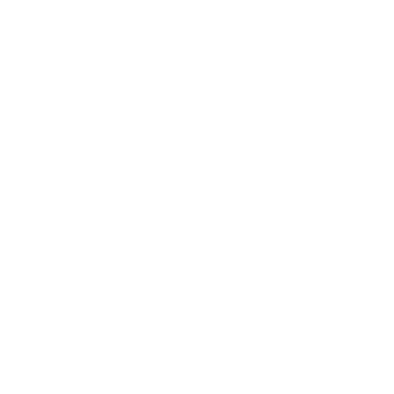

(1, 512, 512)


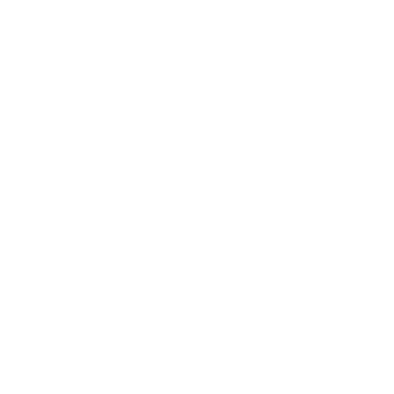

(1, 512, 512)


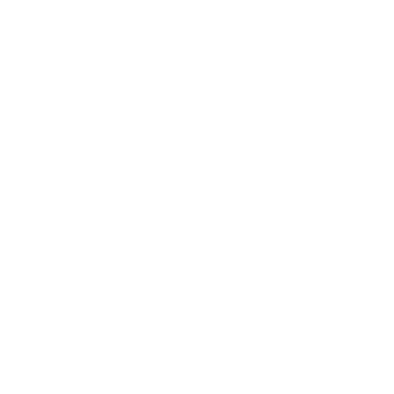

In [90]:
# load the trained model and the test dataset
model = CNN()
model.load_state_dict(torch.load(MODEL_PATH))

# define the target class indices
healthy_idx = test_data.class_to_idx['NORMAL']
disease_idx = test_data.class_to_idx['PNEUMONIA']

one_test_loader = test_loader = DataLoader(test_data, batch_size=1)

# # compute the attribution maps for five healthy and five disease test samples
num_samples = 5
for i, (image, label) in enumerate(one_test_loader):
    image = image.to(device)
    if label == healthy_idx and num_samples > 0:
        attribution_map = integrated_gradients(model, image, healthy_idx, 0)
        num_samples -= 1
    elif label == disease_idx and num_samples > 0:
        attribution_map = integrated_gradients(model, image, disease_idx, )
        num_samples -= 1
    else:
        continue